In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                              labels=actions_labels)
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss = tf.reduce_mean(neg_log_prob * targetQs) # DPG
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    rates = tf.reshape(rates, shape=[-1, 1])
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    # dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
    #                                                                 labels=tf.nn.sigmoid(targetQs))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)
    return g_opt, d_opt, d_optQ

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                        d_loss=self.d_loss, 
                                                        d_lossQ=self.d_lossQ,
                                                        g_learning_rate=g_learning_rate, 
                                                        d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
# gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            glossQ, dlossQ, _ = sess.run([model.g_lossQ, model.d_lossQ, model.d_optQ], 
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        # gloss_list.append([ep, np.mean(gloss_batch)])
        # dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 gloss:0.6903 dloss:0.7296 glossQ:1.0079 dlossQ:0.8866 exploreP:0.9985
Episode:1 meanR:16.5000 R:18.0000 rate:0.0360 gloss:0.6998 dloss:0.7332 glossQ:1.0080 dlossQ:0.8868 exploreP:0.9967
Episode:2 meanR:15.6667 R:14.0000 rate:0.0280 gloss:0.6590 dloss:0.7093 glossQ:1.0108 dlossQ:0.9041 exploreP:0.9954
Episode:3 meanR:15.5000 R:15.0000 rate:0.0300 gloss:0.6844 dloss:0.7246 glossQ:1.0099 dlossQ:0.8969 exploreP:0.9939
Episode:4 meanR:17.8000 R:27.0000 rate:0.0540 gloss:0.6917 dloss:0.7390 glossQ:0.9964 dlossQ:0.8831 exploreP:0.9912
Episode:5 meanR:19.8333 R:30.0000 rate:0.0600 gloss:0.6919 dloss:0.7304 glossQ:1.0091 dlossQ:0.8924 exploreP:0.9883
Episode:6 meanR:22.5714 R:39.0000 rate:0.0780 gloss:0.6908 dloss:0.7288 glossQ:1.0099 dlossQ:0.8978 exploreP:0.9845
Episode:7 meanR:22.3750 R:21.0000 rate:0.0420 gloss:0.6858 dloss:0.7258 glossQ:1.0086 dlossQ:0.8959 exploreP:0.9824
Episode:8 meanR:22.2222 R:21.0000 rate:0.0420 gloss:0.6647 dloss:0.7158 

Episode:71 meanR:26.8750 R:26.0000 rate:0.0520 gloss:0.6965 dloss:0.7342 glossQ:1.0197 dlossQ:0.9414 exploreP:0.8258
Episode:72 meanR:26.9452 R:32.0000 rate:0.0640 gloss:0.6925 dloss:0.7359 glossQ:1.0176 dlossQ:0.9403 exploreP:0.8232
Episode:73 meanR:26.7432 R:12.0000 rate:0.0240 gloss:0.6965 dloss:0.7326 glossQ:1.0239 dlossQ:0.9591 exploreP:0.8222
Episode:74 meanR:27.2000 R:61.0000 rate:0.1220 gloss:0.7027 dloss:0.7380 glossQ:1.0172 dlossQ:0.9512 exploreP:0.8173
Episode:75 meanR:27.1447 R:23.0000 rate:0.0460 gloss:0.7129 dloss:0.7517 glossQ:1.0141 dlossQ:0.9424 exploreP:0.8155
Episode:76 meanR:27.0779 R:22.0000 rate:0.0440 gloss:0.7316 dloss:0.7491 glossQ:1.0169 dlossQ:0.9539 exploreP:0.8137
Episode:77 meanR:27.1154 R:30.0000 rate:0.0600 gloss:0.6988 dloss:0.7376 glossQ:1.0180 dlossQ:0.9410 exploreP:0.8113
Episode:78 meanR:26.9241 R:12.0000 rate:0.0240 gloss:0.6778 dloss:0.7255 glossQ:1.0180 dlossQ:0.9290 exploreP:0.8103
Episode:79 meanR:26.9000 R:25.0000 rate:0.0500 gloss:0.7258 dlos

Episode:141 meanR:45.5600 R:83.0000 rate:0.1660 gloss:0.6935 dloss:0.7360 glossQ:1.0298 dlossQ:0.9656 exploreP:0.5748
Episode:142 meanR:46.2900 R:95.0000 rate:0.1900 gloss:0.7022 dloss:0.7386 glossQ:1.0224 dlossQ:0.9690 exploreP:0.5695
Episode:143 meanR:47.2200 R:143.0000 rate:0.2860 gloss:0.7119 dloss:0.7488 glossQ:1.0194 dlossQ:0.9599 exploreP:0.5615
Episode:144 meanR:47.6000 R:50.0000 rate:0.1000 gloss:0.7262 dloss:0.7495 glossQ:1.0160 dlossQ:0.9632 exploreP:0.5588
Episode:145 meanR:47.9000 R:44.0000 rate:0.0880 gloss:0.7245 dloss:0.7501 glossQ:1.0198 dlossQ:0.9716 exploreP:0.5564
Episode:146 meanR:49.1200 R:149.0000 rate:0.2980 gloss:0.7168 dloss:0.7471 glossQ:1.0257 dlossQ:0.9720 exploreP:0.5483
Episode:147 meanR:49.0000 R:13.0000 rate:0.0260 gloss:0.6989 dloss:0.7425 glossQ:1.0346 dlossQ:0.9749 exploreP:0.5476
Episode:148 meanR:49.9000 R:105.0000 rate:0.2100 gloss:0.7101 dloss:0.7432 glossQ:1.0267 dlossQ:0.9700 exploreP:0.5420
Episode:149 meanR:50.8600 R:106.0000 rate:0.2120 glos

Episode:211 meanR:100.1500 R:106.0000 rate:0.2120 gloss:0.7241 dloss:0.7677 glossQ:1.0281 dlossQ:0.9166 exploreP:0.2633
Episode:212 meanR:101.5300 R:196.0000 rate:0.3920 gloss:0.7293 dloss:0.7683 glossQ:1.0247 dlossQ:0.9076 exploreP:0.2584
Episode:213 meanR:102.2700 R:148.0000 rate:0.2960 gloss:0.7462 dloss:0.7783 glossQ:1.0273 dlossQ:0.9092 exploreP:0.2547
Episode:214 meanR:102.5900 R:109.0000 rate:0.2180 gloss:0.7432 dloss:0.7888 glossQ:1.0163 dlossQ:0.9013 exploreP:0.2521
Episode:215 meanR:103.8100 R:163.0000 rate:0.3260 gloss:0.7326 dloss:0.7721 glossQ:1.0221 dlossQ:0.9048 exploreP:0.2482
Episode:216 meanR:105.6700 R:214.0000 rate:0.4280 gloss:0.7247 dloss:0.7703 glossQ:1.0261 dlossQ:0.9036 exploreP:0.2431
Episode:217 meanR:106.3700 R:98.0000 rate:0.1960 gloss:0.7296 dloss:0.7670 glossQ:1.0234 dlossQ:0.9120 exploreP:0.2409
Episode:218 meanR:107.8100 R:174.0000 rate:0.3480 gloss:0.7248 dloss:0.7738 glossQ:1.0308 dlossQ:0.8973 exploreP:0.2369
Episode:219 meanR:108.0900 R:118.0000 rat

Episode:280 meanR:157.0800 R:151.0000 rate:0.3020 gloss:0.8652 dloss:0.9178 glossQ:1.0318 dlossQ:0.7041 exploreP:0.0892
Episode:281 meanR:157.1000 R:143.0000 rate:0.2860 gloss:0.8554 dloss:0.9041 glossQ:1.0350 dlossQ:0.7139 exploreP:0.0880
Episode:282 meanR:156.4600 R:154.0000 rate:0.3080 gloss:0.8584 dloss:0.9051 glossQ:1.0351 dlossQ:0.7076 exploreP:0.0868
Episode:283 meanR:156.7700 R:152.0000 rate:0.3040 gloss:0.8614 dloss:0.9134 glossQ:1.0355 dlossQ:0.7025 exploreP:0.0857
Episode:284 meanR:157.1600 R:157.0000 rate:0.3140 gloss:0.8837 dloss:0.9182 glossQ:1.0391 dlossQ:0.6978 exploreP:0.0845
Episode:285 meanR:157.4400 R:121.0000 rate:0.2420 gloss:0.8558 dloss:0.9158 glossQ:1.0287 dlossQ:0.6971 exploreP:0.0836
Episode:286 meanR:160.6400 R:343.0000 rate:0.6860 gloss:0.8759 dloss:0.9241 glossQ:1.0408 dlossQ:0.7028 exploreP:0.0811
Episode:287 meanR:161.5000 R:199.0000 rate:0.3980 gloss:0.8819 dloss:0.9271 glossQ:1.0432 dlossQ:0.6979 exploreP:0.0797
Episode:288 meanR:162.6100 R:126.0000 ra

Episode:349 meanR:204.8500 R:244.0000 rate:0.4880 gloss:1.0873 dloss:1.1450 glossQ:1.0770 dlossQ:0.4685 exploreP:0.0272
Episode:350 meanR:205.2500 R:196.0000 rate:0.3920 gloss:1.0808 dloss:1.1234 glossQ:1.0806 dlossQ:0.4791 exploreP:0.0269
Episode:351 meanR:205.2600 R:150.0000 rate:0.3000 gloss:1.0876 dloss:1.1578 glossQ:1.0770 dlossQ:0.5498 exploreP:0.0266
Episode:352 meanR:204.5800 R:136.0000 rate:0.2720 gloss:1.0946 dloss:1.1157 glossQ:1.1036 dlossQ:0.4918 exploreP:0.0264
Episode:353 meanR:204.4700 R:138.0000 rate:0.2760 gloss:1.1144 dloss:1.1521 glossQ:1.0764 dlossQ:0.4598 exploreP:0.0262
Episode:354 meanR:207.6800 R:454.0000 rate:0.9080 gloss:1.0910 dloss:1.1639 glossQ:1.0746 dlossQ:0.4522 exploreP:0.0255
Episode:355 meanR:209.1400 R:292.0000 rate:0.5840 gloss:1.0779 dloss:1.1569 glossQ:1.0730 dlossQ:0.4736 exploreP:0.0250
Episode:356 meanR:209.4200 R:167.0000 rate:0.3340 gloss:1.0716 dloss:1.1324 glossQ:1.0786 dlossQ:0.4913 exploreP:0.0248
Episode:357 meanR:212.3300 R:500.0000 ra

Episode:418 meanR:272.7100 R:459.0000 rate:0.9180 gloss:1.4517 dloss:1.3270 glossQ:1.1059 dlossQ:0.3785 exploreP:0.0124
Episode:419 meanR:276.2400 R:500.0000 rate:1.0000 gloss:1.4874 dloss:1.3939 glossQ:1.1055 dlossQ:0.3967 exploreP:0.0123
Episode:420 meanR:276.8200 R:209.0000 rate:0.4180 gloss:1.4802 dloss:1.4057 glossQ:1.0901 dlossQ:0.3735 exploreP:0.0122
Episode:421 meanR:277.0400 R:182.0000 rate:0.3640 gloss:1.4566 dloss:1.3423 glossQ:1.0852 dlossQ:0.3336 exploreP:0.0122
Episode:422 meanR:278.2500 R:267.0000 rate:0.5340 gloss:1.4633 dloss:1.3397 glossQ:1.0977 dlossQ:0.3556 exploreP:0.0121
Episode:423 meanR:280.2300 R:475.0000 rate:0.9500 gloss:1.5029 dloss:1.3809 glossQ:1.0922 dlossQ:0.3524 exploreP:0.0120
Episode:424 meanR:282.2400 R:368.0000 rate:0.7360 gloss:1.5085 dloss:1.3781 glossQ:1.0816 dlossQ:0.3526 exploreP:0.0120
Episode:425 meanR:280.2000 R:228.0000 rate:0.4560 gloss:1.5045 dloss:1.4151 glossQ:1.0772 dlossQ:0.3153 exploreP:0.0119
Episode:426 meanR:282.1100 R:335.0000 ra

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

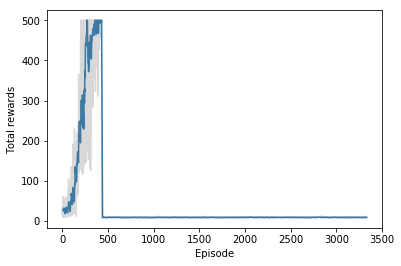

In [18]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

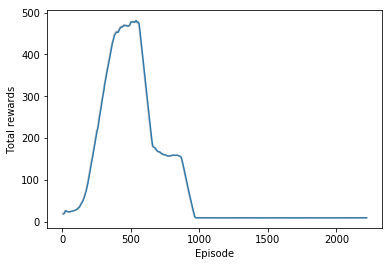

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

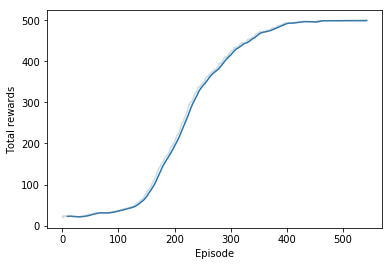

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

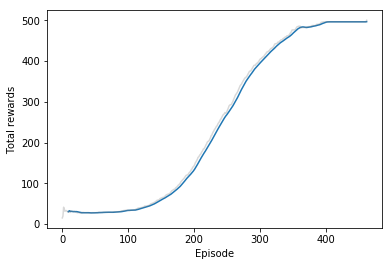

In [21]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

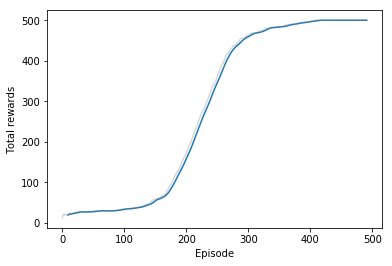

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

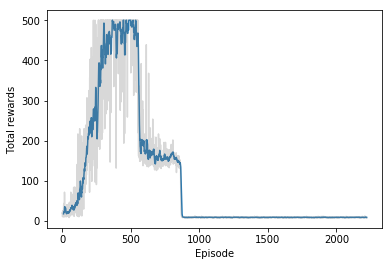

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

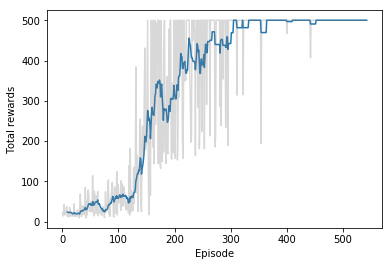

In [17]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

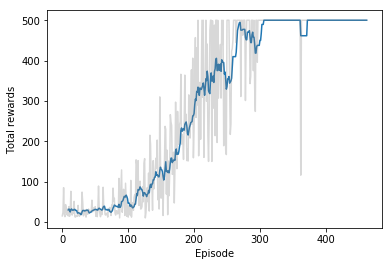

In [22]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

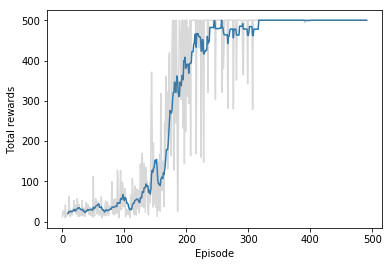

In [63]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')`

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.